In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

# Error rates

In [2]:
err_stats = {}
for folder in os.listdir(".."):
    if folder.startswith("report_"):
        ttype = folder.split("_")[1]

        files = os.listdir("../"+folder)
        success = [x for x in files if x.endswith("json")]
        err = [x for x in files if x.endswith("err")]
        
        err_stats[ttype] = [len(success), len(err)]

df = pd.DataFrame(err_stats, index=["success", "errors"])
df.sort_values("success", axis=1, ascending=False, inplace=True)
df

,clean,trojan,dropper,backdoor,ransomware,rat,coinminer,keylogger
success,25291,12780,11150,11062,9627,9479,6893,4574
errors,569,347,124,26,386,57,2971,3034


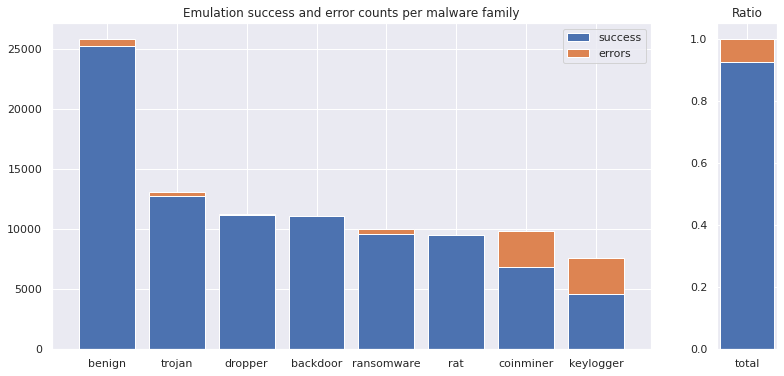

In [3]:
fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [10,1]}, figsize=(13, 6))

success = df.loc["success"]
errors = df.loc["errors"]

ax[0].bar(x=["benign"]+ success.index[1:].tolist(), height=success.values)
ax[0].bar(x=["benign"]+ errors.index[1:].tolist(), height=errors.values, bottom=success.values)
ax[0].set_title("Emulation success and error counts per malware family", fontsize=12)
ax[0].legend(["success", "errors"])

total = df.sum(axis=1)
success_percentage = total["success"]/total.sum()
error_percentage = total["errors"]/total.sum()

ax[1].bar(x="total", height=success_percentage, width=0.4)
ax[1].bar(x="total", height=error_percentage, bottom=success_percentage, width=0.4)
_ = ax[1].set_title("Ratio", fontsize=12)
#ax[1].yaxis.set_label_position("right")
#ax[1].yaxis.tick_right()

In [4]:
# grep -r emulation_logs/ -ie "Err" | cut -d" " -f6- | sed 's/PeX86Exe.*$//' | sed 's/args.*$//'| sed 's/0x[a-f0-9]*//' > errors.lst
with open("errors.lst") as f:
    data = f.readlines()
data = [x.replace("[-]","").strip() for x in data if "ordinal_100" not in x.lower() and len(x.strip()) > 0]

In [5]:
from collections import Counter
c = Counter(data)

In [6]:
c.most_common(15)

[("[DBG]: API nr.: 0; Err: ['invalid_read']; APIs:", 5051),
 ('Failed emulation, UcError: /data/quo.vadis/data/pe.dataset/', 3720),
 ('Failed emulation, NotSupportedError: /data/quo.vadis/data/pe.dataset/',
  724),
 ("['', '']; APIs:", 446),
 ("[DBG]: API nr.: 0; Err: ['Invalid memory write (UC_ERR_WRITE_UNMAPPED)']; APIs:",
  220),
 ('APIs:', 205),
 ("API nr.: 0; Err: ['invalid_read']; APIs:", 173),
 ('UcError(status)', 108),
 ("[DBG]: API nr.: 0; Err: ['Invalid memory read (UC_ERR_READ_UNMAPPED)']; APIs:",
  103),
 ("[DBG]: API nr.: 0; Err: ['', '']; APIs:", 91),
 ('./errors.lst:UcError(status)', 73),
 ('./errors.lst:./errors.lst:UcError(status)', 73),
 ("['invalid_read']; APIs:", 71),
 ("[DBG]: API nr.: 0; Err: ['Invalid instruction (UC_ERR_INSN_INVALID)']; APIs:",
  68),
 ("API nr.: 0; Err: ['', '']; APIs:", 66)]

In [7]:
weird = c.most_common(10)[3][0] # empty error from Speakeasy
[x for x in data if weird in x][0:5]

["[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:"]

# Distinct API counts

In [33]:
import sys, ast
sys.path.append("../../../")
#from preprocessing.reports import report_to_apiseq
from utils.functions import flatten

# report_apiseqlist = []
# for folder in os.listdir(".."):
#     if folder.startswith("report_"):
#         print("\n",folder)
#         files = os.listdir("../"+folder)
#         reports = [x for x in files if x.endswith("json")]
#         for i,report in enumerate(reports):
#             print(f"{i}/{len(reports)}", end="\r")
#             report_apiseqlist.append(report_to_apiseq("../"+folder+"/"+report))
            
# df = pd.DataFrame(report_apiseqlist)
# df["api.seq"] = df["api.seq"].apply(lambda x: ast.literal_eval(x))
# df.to_csv("apiseqdf.csv", index=False)
# del report_apiseqlist

df = pd.read_csv("apiseqdf.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,sha256,api.seq,api.seq.len
0,0,0,f4ef0148f6c6967795260d9b8ac5653d5d4edf9cb7e2bd...,"['kernel32.virtualalloc', 'kernel32.virtualfre...",450
1,1,1,63897bc95bc304fd273fbf5faf1eac08c7673e96690d25...,"['kernel32.loadlibrarya', 'kernel32.getprocadd...",147
2,2,2,f60c15662e4dc06d9176f9e9bdb1601a82a65895cc601c...,"['crtdll.__getmainargs', 'kernel32.getcommandl...",501
3,3,3,63b143e1ec7341901adea6e760c8df8eec7738d23c4987...,"['kernel32.getversion', 'kernel32.heapcreate',...",54
4,4,4,cd28406050c2c8868f423f1600ae051da59e1d3f6222b0...,"['kernel32.getsystemtimeasfiletime', 'kernel32...",451


In [41]:
from collections import Counter
apicounts = Counter(flatten(df["api.seq"].values))
values = [x[1] for x in apicounts.most_common()]
unique_apis = [x[0] for x in apicounts]

In [46]:
len(unique_apis)

2822

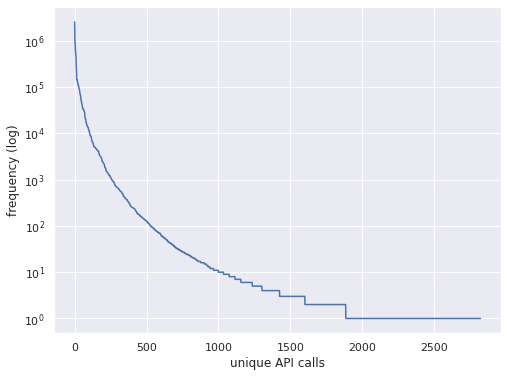

In [45]:
plt.figure(figsize=(8,6))
plt.plot(values)
plt.ylabel("frequency (log)")
plt.xlabel("unique API calls")
# plt.xlim([0,1500])
_ = plt.yscale("log")

In [119]:
def get_portion(counter, threshold):
    included_api_count = np.sum([x[1] for x in counter.most_common(threshold)])
    total_count = np.sum(list(counter.values()))
    return included_api_count, included_api_count/total_count

print(f"Top i API calls represent following portion of all calls:")
for i in [50, 100, 150, 200, 300, 400, 500, 600, 700]:
    ratio = get_portion(apicounts, i)[1]
    print(f"\t{i} : {ratio:.4f}")

Top i API calls represent following portion of all calls:
	50 : 0.8826
	100 : 0.9553
	150 : 0.9767
	200 : 0.9873
	300 : 0.9948
	400 : 0.9974
	500 : 0.9985
	600 : 0.9991
	700 : 0.9994


In [6]:
apicounts.most_common(15)

[('kernel32.getprocaddress', 2536899),
 ('kernel32.isbadreadptr', 1891588),
 ('kernel32.tlsgetvalue', 987392),
 ('kernel32.initializecriticalsectionex', 936742),
 ('kernel32.flsgetvalue', 718695),
 ('kernel32.heapalloc', 667898),
 ('kernel32.leavecriticalsection', 569049),
 ('kernel32.entercriticalsection', 562499),
 ('kernel32.getlasterror', 487061),
 ('kernel32.setlasterror', 464498),
 ('kernel32.encodepointer', 452307),
 ('kernel32.initializecriticalsectionandspincount', 278600),
 ('kernel32.decodepointer', 251797),
 ('kernel32.multibytetowidechar', 213518),
 ('kernel32.getcpinfoexw', 143376)]

Text(0.5, 0, 'API calls')

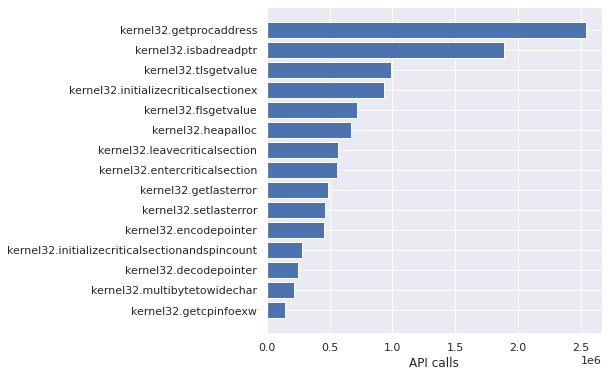

In [49]:
plt.figure(figsize=(6,6))
plt.barh(y = [x[0] for x in apicounts.most_common(15)][::-1], width=[x[1] for x in apicounts.most_common(15)][::-1])
plt.xlabel("API calls")

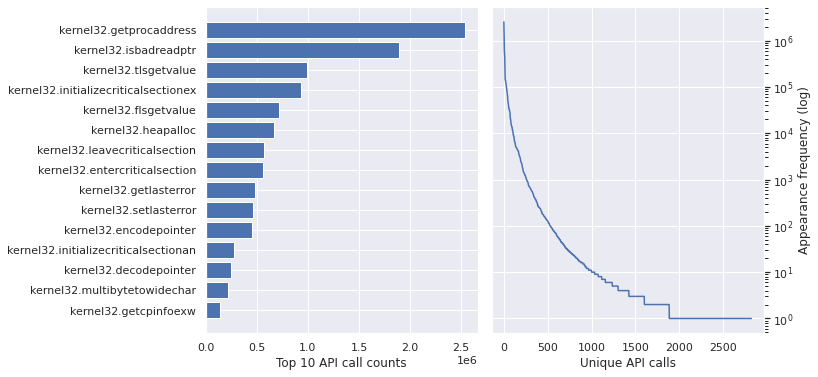

In [81]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

ax[0].barh(y = [x[0][:36] for x in apicounts.most_common(15)][::-1], width=[x[1] for x in apicounts.most_common(15)][::-1])
ax[0].set_xlabel("Top 10 API call counts")

ax[1].plot(values)
ax[1].set_ylabel("Appearance frequency (log)")
ax[1].set_xlabel("Unique API calls")
# plt.xlim([0,1500])
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
_ = ax[1].set_yscale("log")

plt.subplots_adjust(wspace=0.05)

## short sequence examples

In [87]:
short_sequences = df[df["api.seq.len"] == 2]["api.seq"]

short_sequences.iloc[0]

['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']

In [88]:
short_sequences.iloc[1]

['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']

In [90]:
short_sequences.iloc[2]

['kernel32.showconsolecursor', 'kernel32.getuserdefaultuilanguage']

In [118]:
[print(x) for x in short_sequences if 'msvbvm60.ordinal_100' not in x]

['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']
['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']
['kernel32.showconsolecursor', 'kernel32.getuserdefaultuilanguage']
['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']
['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']
['oleaut32.getmodulehandlea', 'oleaut32.getprocaddress']
['crtdll.__getmainargs', 'crtdll._initterm']
['crtdll.__getmainargs', 'crtdll._initterm']
['comctl32.ordinal_17', 'kernel32.getmodulehandlea']
['kernel32.getstartupinfow', 'advapi32.regopenkeya']
['crtdll.__getmainargs', 'crtdll._initterm']
['crtdll.__getmainargs', 'crtdll._initterm']
['crtdll.__getmainargs', 'crtdll._initterm']
['user32.loadicona', 'user32.loadcursora']
['crtdll.__getmainargs', 'crtdll._initterm']
['crtdll.__getmainargs', 'crtdll._initterm']
['kernel32.getstartupinfoa', 'kernel32.getmodulehandlea']
['kernel32.getstartupinfoa', 'kernel32.getmodulehandlea']
['crtdll.__getmainargs', 'crtdll._initterm']
['crtdll.__getmainargs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [102]:
def match_sequence(x, sequence=['kernel32.showconsolecursor', 'kernel32.getuserdefaultuilanguage']):
    if x == sequence:
        return True
    else:
        return False

df["api.seq"].apply(match_sequence)

0        False
1        False
2        False
3        False
4        False
         ...  
90851    False
90852    False
90853    False
90854    False
90855    False
Name: api.seq, Length: 90856, dtype: bool

In [112]:
Counter([set(x) for x in short_sequences.values])

TypeError: unhashable type: 'set'